In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from deepsm.graphspn.tbm.topo_map import PlaceNode, TopologicalMap
from deepsm.graphspn.tbm.spn_template import NodeTemplateSpn, EdgeRelationTemplateSpn
from deepsm.graphspn.tbm.spn_instance import NodeTemplateInstanceSpn, EdgeRelationTemplateInstanceSpn
from deepsm.graphspn.tbm.template import NodeTemplate, PairTemplate, SingletonTemplate, ThreeNodeTemplate, StarTemplate, \
    EdgeRelationTemplate, ThreeRelTemplate, RelTemplate, SingleRelTemplate, SingleTemplate
from deepsm.graphspn.tbm.algorithm import NodeTemplatePartitionSampler
import numpy as np
import deepsm.util as util
from deepsm.graphspn.tbm.dataset import TopoMapDataset
from deepsm.experiments.common import COLD_ROOT, GRAPHSPN_RESULTS_ROOT, TOPO_MAP_DB_ROOT, GROUNDTRUTH_ROOT
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pylab import rcParams
import tensorflow as tf
import os, sys
from pprint import pprint

In [3]:
util.CategoryManager.TYPE = "SIMPLE"
util.CategoryManager.init()

db = "Freiburg"

dataset = TopoMapDataset(TOPO_MAP_DB_ROOT)
dataset.load(db, skip_unknown=True, skip_placeholders=True, single_component=True)
coldmgr = util.ColdDatabaseManager(db, COLD_ROOT)

seq_id = "seq3_cloudy1"
topo_map = dataset.get(db, seq_id)

In [4]:
sampler = NodeTemplatePartitionSampler(topo_map=topo_map)

### Parameter investigation

Among these parameters, which one has the highest variance across partitions?

In [5]:
# Randomly partition 500 times
params = {'complexity':[], 'straight':[], 'dom':[], 'separable':[], 'similarity':[]}
for i in range(100):
    p = sampler.random_partition()
    params['complexity'].append(sampler._complexity(partition=p))
    params['straight'].append(sampler._straight_template(partition=p))
    params['dom'].append(sampler._degree_of_middle_node(partition=p))
    params['separable'].append(sampler._separable_by_middle_node(partition=p))
    
    
for i in range(20):
    partitions = []
    sims = []
    for j in range(10):
        p = sampler.random_partition()
        sims.append(sampler._similarity(partition=p, partitions=partitions))
        partitions.append(p)
    params['similarity'].append(np.mean(sims))
    
# # Print statistics for each parameter
# for param in params:
#     print("%s:" % param)
#     print("       mean: %.4f" % np.mean(params[param]))
#     print("        std: %.4f" % np.std(params[param]))
#     print("  coeff-var: %.4f%%" % (np.std(params[param])/np.mean(params[param])*100))
#     print("     median: %.4f" % np.median(params[param]))
#     print("      range: %.4f\n" % (np.max(params[param]) - np.min(params[param])))
#     print("  - exponentiate -\n")
#     print("%s:" % param)
#     exp_params = np.exp(params[param])
#     print("       mean: %.4f" % np.mean(exp_params))
#     print("        std: %.4f" % np.std(exp_params))
#     print("  coeff-var: %.4f%%" % (np.std(exp_params)/np.mean(exp_params)*100))
#     print("     median: %.4f" % np.median(exp_params))
#     print("      range: %.4f" % (np.max(exp_params) - np.min(exp_params)))
#     print("-------------------")

In [6]:
# Parameters
params = {
    'similarity_coeff': -0.5,
    'complexity_coeff': 3,
    'straight_template_coeff': 10,
    'dom_coeff': 3,
    'separable_coeff': 10
}
sampler.set_params(**params)

In [68]:
def factor_correlations(factor_names, num_rounds=20, num_partitions=5,
                        params=None, plot=False, dbs=['Stockholm', 'Freiburg', 'Saarbrucken'], num_seqs=10):
    """Sample a bunch of partitions. Then, for each parameter, plot each partition's value for that parameter
    versus the partition's energy. See if they correlate in the way we want.
    
    Returns a dictionary of the format:
    
        factor name -> {
            db_name -> {
                factor_name -> correlation_coefficient
            }
            _average_ -> average correlation coefficient
        }
    
    that maps from factor name to correlation coefficient of that factor to energy.
    """
    def corr_plot(ax, x, y, xlabel):
        ax.scatter(x, y)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("energy")
    
    result = {}
    dataset = TopoMapDataset(TOPO_MAP_DB_ROOT)
                             
    for db in dbs:
        print("On DB %s" % db)
        dataset.load(db, skip_unknown=True, skip_placeholders=True, single_component=True)
        topo_maps = dataset.get_topo_maps(db_name=db, amount=num_seqs)
        
        x = {}
        y = {}
    
        for seq_id in topo_maps:
            topo_map = topo_maps[seq_id]
            sampler = NodeTemplatePartitionSampler(topo_map=topo_map)
            if params is not None:
                sampler.set_params(**params)

            partition_sets, attributes = sampler.sample_partition_sets(num_rounds, num_partitions)

            for i in range(len(partition_sets)):
                for f in factor_names:
                    if f not in x:
                        x[f] = []
                        y[f] = []
                    for j, p in enumerate(partition_sets[i]):
                        attr = attributes[i]
                        if f in attr['factors'][j]:
                            x[f].append(attr['factors'][j][f])
                            y[f].append(attr['energies'][j])
                            
        if plot:
            fig, axes = plt.subplots(len(factor_names)//3+1, 3, sharey=True)
            fig.suptitle('%s' % db)
            for i, p in enumerate(factor_names):
                # Plot
                corr_plot(axes[i//3,i%3], x[p], y[p], p)
                
                
        # Compute correlation coefficent
        for f in factor_names:
            if f not in result:
                result[f] = {}
            result[f][db] = np.corrcoef(x[f], y[f])
            
    for f in factor_names:
        result[f]['_average_'] = np.mean([result[f][db] for db in dbs])
    return result

In [8]:
rcParams['figure.figsize'] = 12, 8
factor_correlations(['complexity', 'straight', 'dom', 'separable', 'similarity'], num_rounds=5, num_seqs=5)

On DB Stockholm
round 5/5
round 5/5
round 5/5
round 5/5
On DB Freiburg
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
On DB Saarbrucken
round 5/5
round 5/5
round 5/5
round 5/5


{'complexity': {'Freiburg': array([[ 1.        , -0.04714709],
         [-0.04714709,  1.        ]]),
  'Saarbrucken': array([[ 1.        ,  0.12005637],
         [ 0.12005637,  1.        ]]),
  'Stockholm': array([[ 1.        , -0.25030343],
         [-0.25030343,  1.        ]]),
  '_average_': 0.470434307274052},
 'dom': {'Freiburg': array([[ 1.        , -0.15224182],
         [-0.15224182,  1.        ]]),
  'Saarbrucken': array([[ 1.       ,  0.0866365],
         [ 0.0866365,  1.       ]]),
  'Stockholm': array([[ 1.        , -0.17444439],
         [-0.17444439,  1.        ]]),
  '_average_': 0.4599917154933702},
 'separable': {'Freiburg': array([[ 1.        , -0.45880138],
         [-0.45880138,  1.        ]]),
  'Saarbrucken': array([[ 1.        , -0.39849996],
         [-0.39849996,  1.        ]]),
  'Stockholm': array([[ 1.        , -0.48021731],
         [-0.48021731,  1.        ]]),
  '_average_': 0.27708022403422189},
 'similarity': {'Freiburg': array([[ 1.        ,  0.136223

In [9]:
def random_search(params, ranges, desired, factor_names,
                  rounds=50, **fc_params):
    """Goal is to find a set of parameters that best separate the
    different partitions, and maximize desired correlation with
    the energy.
    
    The ith element in `desired` should be 1 if we hope the ith
    parameter to have a positive correlation with the energy. -1
    if otherwise.
    
    The ith element in prarams should be the coefficient for the
    ith element in factor_names.
    """
    best_setting = {}
    best_corrs = {}
    lowest_avg_gap = float('inf')
    for r in range(rounds):
        sys.stdout.write('*** round %d/%d ***\n' % (r+1, rounds)); sys.stdout.flush()
        setting = {}
        gaps = []
        for i in range(len(params)):
            setting[params[i]] = np.random.uniform(low=ranges[i][0], high=ranges[i][1])
        print(setting)
        
        corrs = factor_correlations(factor_names, **fc_params)
        for i in range(len(params)):
            f = factor_names[i]
            gaps.append(abs(desired[i] - corrs[f]['_average_']))
        
        avg_gap = np.mean(gaps)
        if avg_gap < lowest_avg_gap:
            lowest_averge_gap = avg_gap
            best_setting = setting
            best_corrs = corrs
            
    return best_setting, best_corrs, lowest_avg_gap
    

In [70]:
factor_names=['complexity', 'straight', 'dom', 'separable', 'similarity']
params = ['similarity_coeff', 'complexity_coeff', 'straight_template_coeff', 'dom_coeff', 'separable_coeff']
ranges = [(-5, -0.05), (1, 10), (1, 10), (1, 10), (1, 10)]
desired = [1, -1, -1, -1, -1]

In [ ]:
best_setting, best_corrs, lowest_avg_gap = random_search(params, ranges, desired, factor_names, rounds=200, num_seqs=5,
                                                        dbs=['Stockholm', 'Freiburg', 'Saarbrucken'], num_rounds=10)

On DB Stockholm
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
On DB Freiburg
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
On DB Saarbrucken
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5


{'complexity': {'Freiburg': array([[ 1.        , -0.03655916],
         [-0.03655916,  1.        ]]),
  'Saarbrucken': array([[ 1.        , -0.09315472],
         [-0.09315472,  1.        ]]),
  'Stockholm': array([[ 1.       , -0.0703468],
         [-0.0703468,  1.       ]]),
  '_average_': 0.46665655467244677},
 'dom': {'Freiburg': array([[ 1.       , -0.2679658],
         [-0.2679658,  1.       ]]),
  'Saarbrucken': array([[ 1.        , -0.32165118],
         [-0.32165118,  1.        ]]),
  'Stockholm': array([[ 1.       , -0.2601947],
         [-0.2601947,  1.       ]]),
  '_average_': 0.35836471976839995},
 'separable': {'Freiburg': array([[ 1.        , -0.10633994],
         [-0.10633994,  1.        ]]),
  'Saarbrucken': array([[ 1.        ,  0.04429819],
         [ 0.04429819,  1.        ]]),
  'Stockholm': array([[ 1.        , -0.18971679],
         [-0.18971679,  1.        ]]),
  '_average_': 0.4580402437883882},
 'similarity': {'Freiburg': array([[ 1.        ,  0.29963708],
 

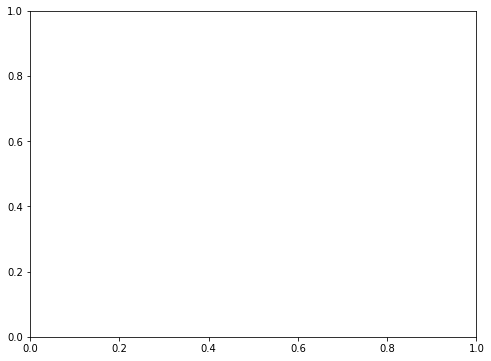

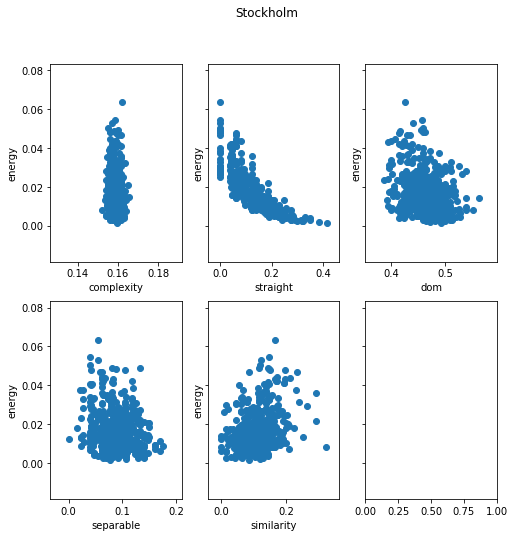

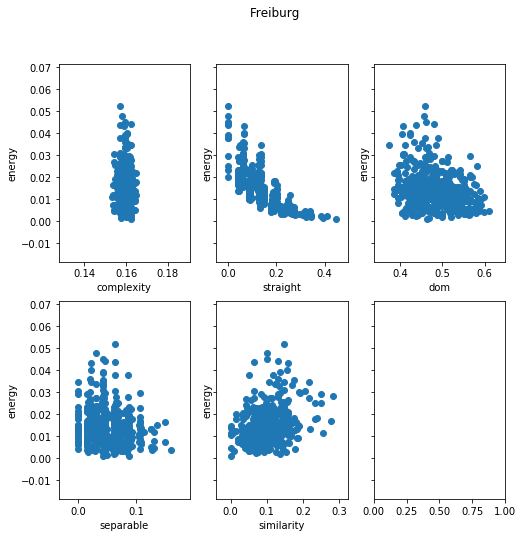

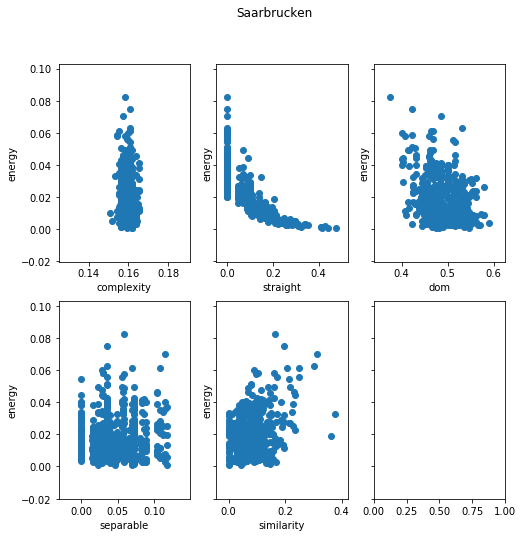

In [73]:
rcParams['figure.figsize'] = 8, 8
factor_correlations(factor_names, num_rounds=5, num_partitions=8, num_seqs=15,
                    params=best_setting, plot=True, dbs=['Stockholm', 'Freiburg', 'Saarbrucken'])

In [13]:
print(best_setting)

{'separable_coeff': 2.1314365714437775, 'straight_template_coeff': 7.997020601228423, 'complexity_coeff': 6.8987258916531236, 'similarity_coeff': -3.2892620362926266, 'dom_coeff': 4.8590878043033126}


In [5]:
best_setting = {'dom_coeff': 4.8590878043033126, 'straight_template_coeff': 7.997020601228423, 'complexity_coeff': 6.8987258916531236, 'similarity_coeff': -3.2892620362926266, 'separable_coeff': 2.1314365714437775}
sampler.set_params(**best_setting)

### Energy Distribution

In [15]:
partition_sets, attributes = sampler.sample_partition_sets(15, 10)
energies = [attributes[i]['energies'] for i in range(len(attributes))]
exponents = [-np.log(energies[i]) for i in range(len(energies))]

round 15/15


In [31]:
# Plot
def energy_plot(ax, exponents, energies, label="partition"):
    ax.scatter(exponents, energies, label=label)
    ax.set_xlabel("exponent")
    ax.set_ylabel("energy")
    ax.axhline(y=np.mean(energies), color='orange', label='mean=%.3f' % (np.mean(energies)))

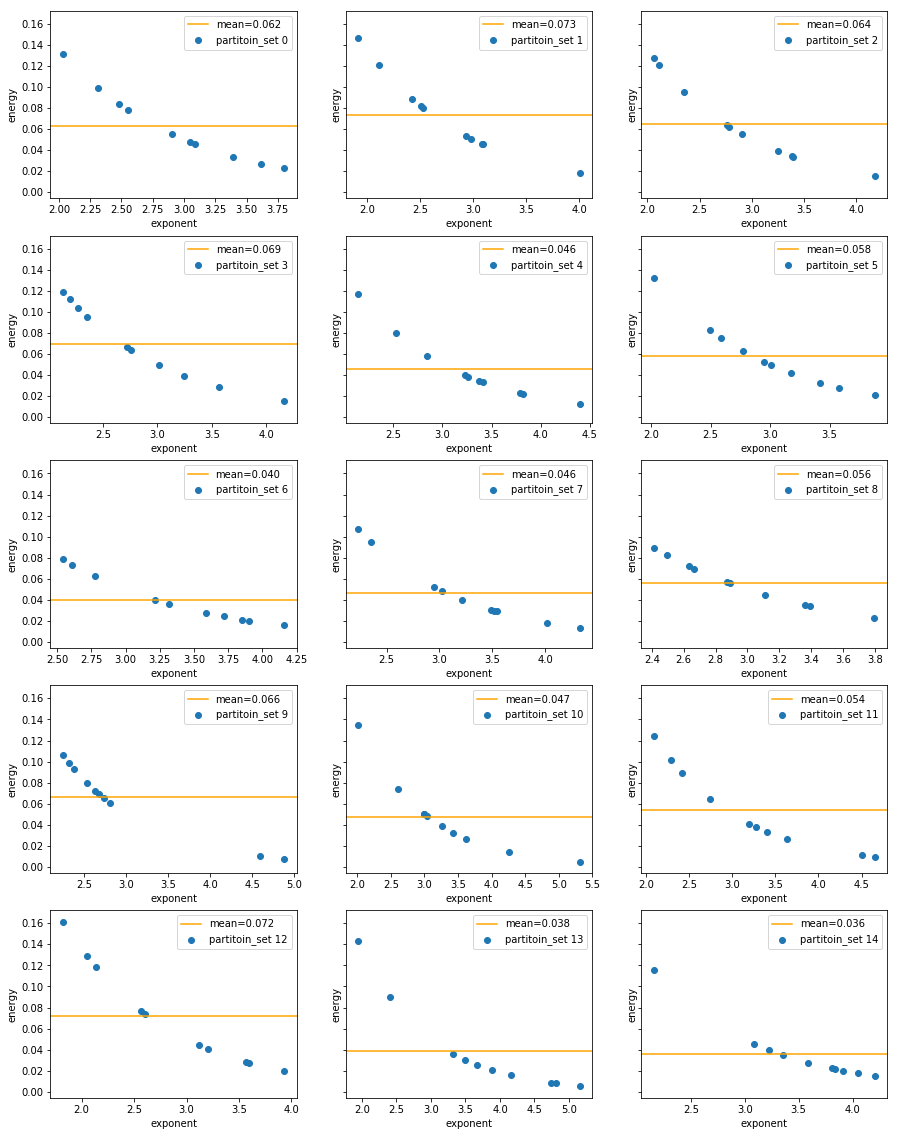

In [24]:
rcParams['figure.figsize'] = 15, 20

f, axes = plt.subplots(len(energies)//3, 3, sharey=True)

for i in range(len(energies)):
    energy_plot(axes[i//3, i%3], exponents[i], energies[i], label="partitoin_set %d" % (i))
    axes[i//3, i%3].legend(loc='upper right')
plt.show()

### Select Best Partitions

In [6]:
# Use partition with lowest median
# partition_sets, energies, exponents = sample_partition_sets(10, 15, use_object_method=False)
def order(partition_sets, energies):
    indices = sorted(range(len(energies)), key=lambda i:np.median(energies[i]))
    return indices

In [7]:
indices = order(partition_sets, energies)
top_partition_set = partition_sets[indices[0]]

rcParams['figure.figsize'] = 5, 4
energy_plot(plt.gca(), exponents[indices[0]], energies[indices[0]], label='partition %d' % indices[0])
plt.legend(loc='upper right')
plt.show()

NameError: name 'partition_sets' is not defined

partitions/Saved seq3_cloudy1-0.png


ValueError: object too deep for desired array

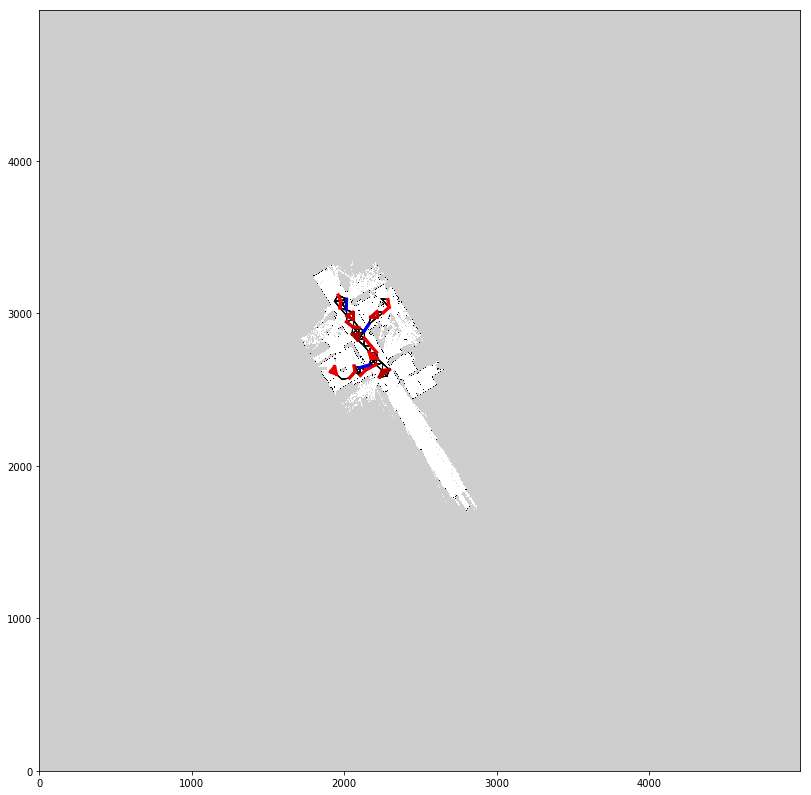

In [27]:
# Visualize
rcParams['figure.figsize'] = 22, 14
for i, partition in enumerate(top_partition_set):
    sampler.visualize_partition(partition, coldmgr.groundtruth_file(seq_id.split("_")[0], 'map.yaml'))
    plt.savefig('partitions/%s-%d.png' % (seq_id, i))
    plt.clf()
    print("partitions/Saved %s-%d.png" % (seq_id, i))

### Random Partitions

In [ ]:
os.makedirs("partitions/random", exist_ok=True)
partitions = []
energies = []
exponents = []
rcParams['figure.figsize'] = 22, 14
for i in range(10):
    p = sampler.random_partition()
    e, _ = sampler.energy(partition=p, partitions=partitions)
    energies.append(e)
    exponents.append(-np.log(e))
    
    sampler.visualize_partition(p, coldmgr.groundtruth_file(seq_id.split("_")[0], 'map.yaml'))
    plt.savefig('partitions/random/%s-%d.png' % (seq_id, i))
    plt.clf()
    print("partitions/random Saved %s-%d.png" % (seq_id, i))
    partitions.append(p)

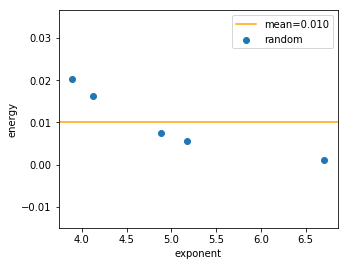

In [32]:
rcParams['figure.figsize'] = 5, 4
energy_plot(plt.gca(), exponents, energies, label='random')
plt.legend(loc='upper right')
plt.show()

## Sample More

In [57]:
partition_sets, attributes, best_index = sampler.sample_partition_sets(100, 5, pick_best=True)
top_pset = partition_sets[best_index]
attributes = attributes[best_index]

round 100/100


In [58]:
energies = attributes['energies']
exponents = [-np.log(e) for e in energies]

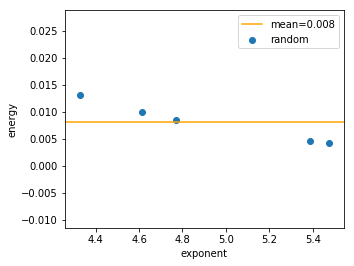

In [59]:
rcParams['figure.figsize'] = 5, 4
energy_plot(plt.gca(), exponents, energies, label='random')
plt.legend(loc='upper right')
plt.show()

## Try it on GraphSPN

In [63]:
# Construct GraphSPN from partitions

import yaml
with open("likelihoods/likelihoods_Freiburg_seq3_cloudy1.yaml") as f:
    dgsm_lh = yaml.load(f)['likelihoods']
    
### Build graphspn

sess = tf.Session()

tspn3 = NodeTemplateSpn(ThreeNodeTemplate, seed=100)
tspn2 = NodeTemplateSpn(PairTemplate, seed=100)
tspn1 = NodeTemplateSpn(SingletonTemplate, seed=100)

#### Load Template SPNs from files

spn3_path = "models/ThreeNodeTemplate_4_Freiburg12.spn"
spn2_path = "models/PairTemplate_4_Freiburg12.spn"
spn1_path = "models/SingletonTemplate_4_Freiburg12.spn"

tspn3.load(spn3_path, sess)
tspn2.load(spn2_path, sess)
tspn1.load(spn1_path, sess)

sess.run(tspn1.root.weights.node.get_value())

tspns = [(tspn3, ThreeNodeTemplate), (tspn2, PairTemplate), (tspn1, SingletonTemplate)]

for template_spn, _ in tspns:
    template_spn._conc_inputs.set_inputs()

ispn = NodeTemplateInstanceSpn(topo_map, sess, *tspns, partitions=top_pset,
                               seq_id=seq_id, divisions=8, db_name="Freiburg", visualize_partitions_dirpath="./partitions")

ispn.expand()

ispn.init_ops(no_mpe=True)

query_nids = [nid for nid in topo_map.nodes]
query = {nid:-1 for nid in topo_map.nodes}
query_lh = dgsm_lh
marginals = ispn.marginal_inference(sess, query_nids, query, query_lh=query_lh)

true_catg_map = topo_map.current_category_map()
result_catg_map = {}
query_catg_map = {}
for nid in query:
    result_catg_map[nid] = marginals[nid].index(max(marginals[nid]))
    query_catg_map[nid] = query_lh[nid].tolist().index(max(query_lh[nid]))

floor = seq_id.split("_")[0]
topo_map.assign_categories(true_catg_map)



[INFO] [spn.JSONLoader:load] Loading SPN graph from file 'models/ThreeNodeTemplate_4_Freiburg12.spn'


Generating SPN structure...
[Using seed 100]
Generating SPN structure...
[Using seed 100]
Generating SPN structure...
[Using seed 100]


[INFO] [spn.JSONLoader:load] Loading SPN graph from file 'models/PairTemplate_4_Freiburg12.spn'
[INFO] [spn.JSONLoader:load] Loading SPN graph from file 'models/SingletonTemplate_4_Freiburg12.spn'


Importing matplotlib...
Building instance spn...
Partition 1
Will duplicate ThreeNodeTemplate 13 times.
Duplicating ThreeNodeTemplate... 1 2 3 4 5 6 7 8 9 10 11 12 13 


/home/zkytony/Documents/thesis/experiments/deep-semantic-mapping/deepsm/graphspn/tbm/spn_instance.py:273: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zkytony/py3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zkytony/py3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zkytony/py3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start

Will duplicate PairTemplate 2 times.
Duplicating PairTemplate... 1 2 
Will duplicate SingletonTemplate 5 times.
Duplicating SingletonTemplate... 1 2 3 4 5 
Visualized partition 1
Partition 2
Will duplicate ThreeNodeTemplate 13 times.
Duplicating ThreeNodeTemplate... 1 2 3 4 5 6 7 8 9 10 11 12 13 
Will duplicate PairTemplate 1 times.
Duplicating PairTemplate... 1 
Will duplicate SingletonTemplate 7 times.
Duplicating SingletonTemplate... 1 2 3 4 5 6 7 
Visualized partition 2
Partition 3
Will duplicate ThreeNodeTemplate 13 times.
Duplicating ThreeNodeTemplate... 1 2 3 4 5 6 7 8 9 10 11 12 13 
Will duplicate PairTemplate 2 times.
Duplicating PairTemplate... 1 2 
Will duplicate SingletonTemplate 5 times.
Duplicating SingletonTemplate... 1 2 3 4 5 
Visualized partition 3
Partition 4
Will duplicate ThreeNodeTemplate 14 times.
Duplicating ThreeNodeTemplate... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Will duplicate PairTemplate 1 times.
Duplicating PairTemplate... 1 
Will duplicate SingletonTemplate 

In [64]:

# Visualize
def vis_map(topo_map, floor, catg_map):
    topo_map.assign_categories(catg_map)
    rcParams['figure.figsize'] = 22, 14
    topo_map.visualize(plt.gca(), coldmgr.groundtruth_file(floor, 'map.yaml'), consider_placeholders=False)

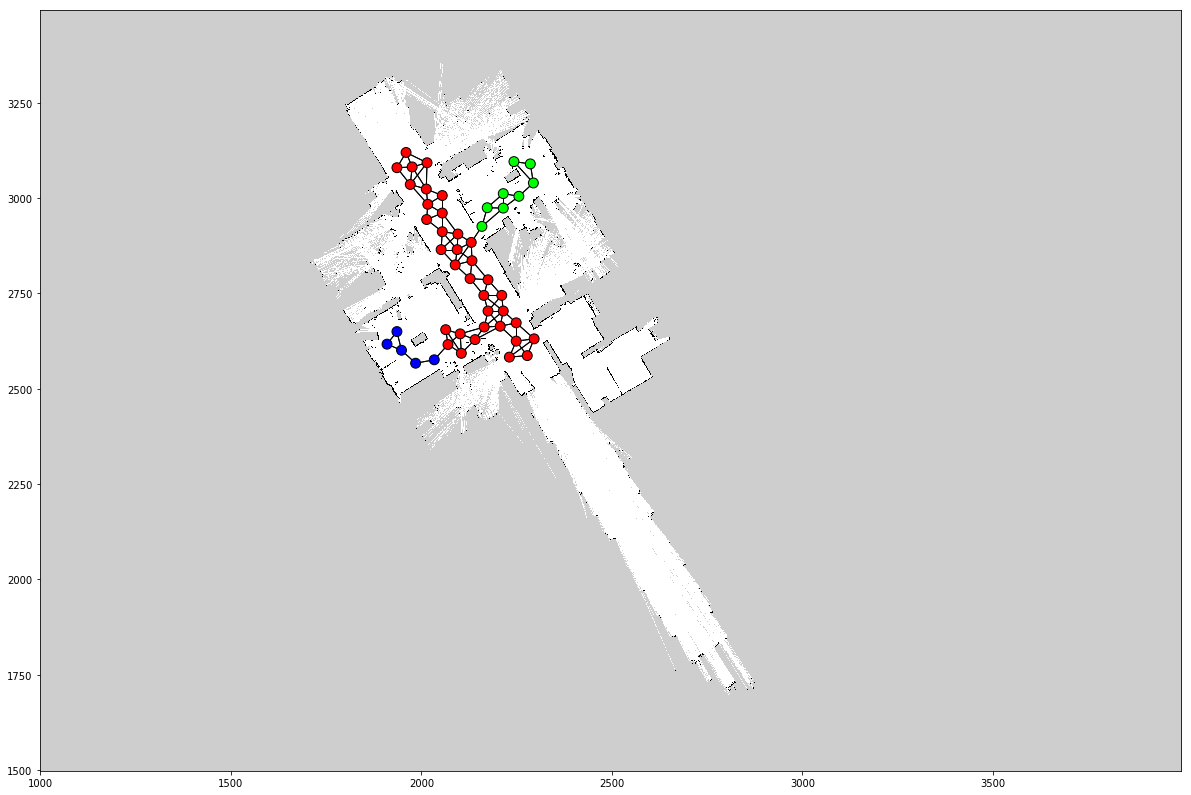

In [65]:
vis_map(topo_map, floor, result_catg_map)

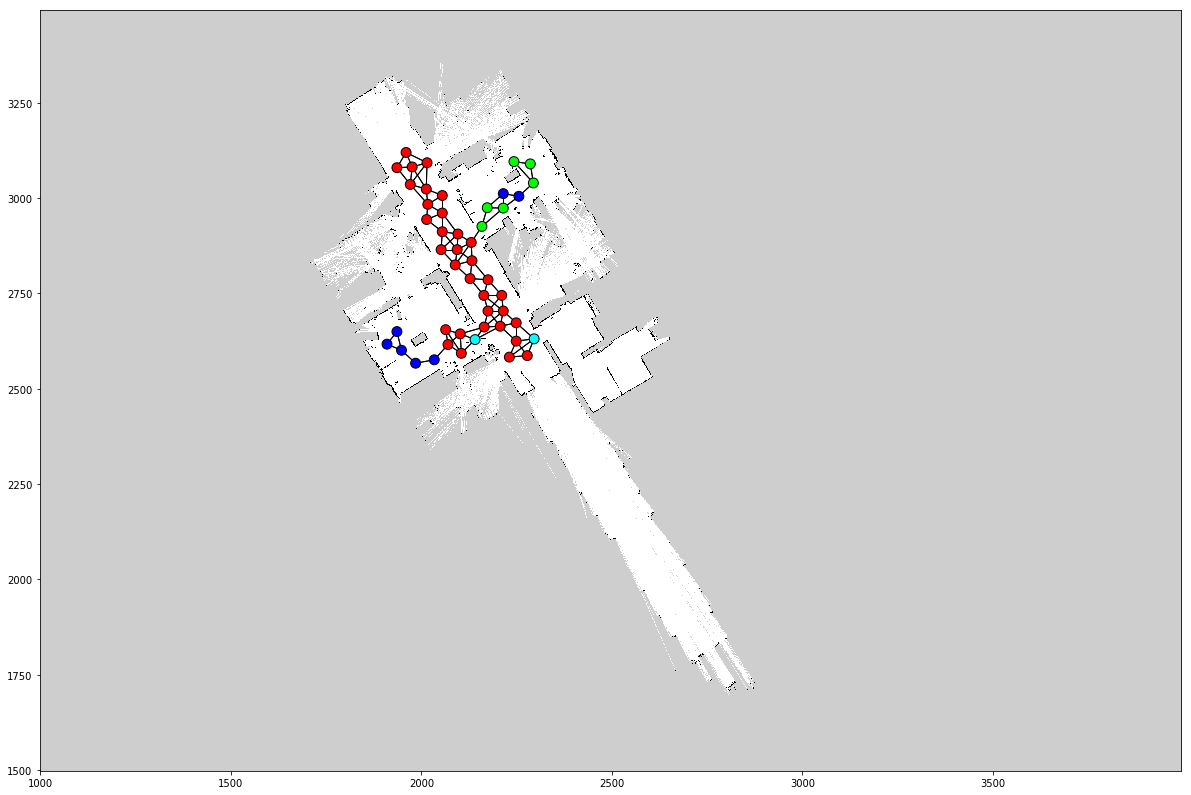

In [66]:
vis_map(topo_map, floor, query_catg_map)